Linear Regression Model: Predicting Discount Utilization

have both discountoffered and discountused in your dataset, you could build a model to predict how much of a discount will be utilized when offered. 
This has real business value because it helps optimize discount strategies and maximize revenue.

Business Value:
1. Discount Optimization: Knowing which factors influence discount utilization helps in tailoring discount offers to maximize both usage and profitability.
2. Profit Protection: By understanding discount utilization drivers, you can avoid offering unnecessary discounts in situations where they're unlikely to be used.

Let's start 😉

1. Preprocess the data:
* Cleaning (handling missing values, removing duplicates)
* Normalization/standardization
* Encoding categorical variables
* Handling outliers

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore') 
import os #provides functions for interacting with the operating system


# To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
%matplotlib inline

In [2]:
import pypyodbc as podbc

conn2 = podbc.connect("Driver={SQL Server Native Client 11.0};"
                     "Server=LAPTOP_LYNDA;"
                     "Database=DW_Finance;"
                     "Trusted_Connection=yes;")

# rynning the SQL query i need
df= pd.read_sql_query('''SELECT * FROM [dbo].[Fact_Audit]''', conn2)

# Viz
df.head()

,fk_dispute,fk_supplier,fk_paymentsupp,fk_statment,fk_produit,fk_date,amountdue,amountpaid,balancedue,equity,amount,discountoffered,discountused,vatrate,recommendedprofitmargin
0,6979,8,6,5776,24,1162,4038.0,2584.0,1454.0,195230.0,820.28,71.79,40.36,20.0,39.76
1,6979,8,879,2304,24,1162,2341.0,857.0,1484.0,298726.0,385.87,317.41,200.40,20.0,39.76
2,6994,6,451,2695,21,1308,3267.0,2206.0,1061.0,188752.0,2810.11,456.71,270.01,5.5,33.67
3,6986,10,951,4967,25,425,4402.0,3314.0,1088.0,147330.0,1102.56,134.77,125.30,10.0,39.71
4,6979,8,918,3956,24,1162,1950.0,1453.0,497.0,381373.0,3933.67,12.76,1.56,20.0,39.76


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fk_dispute               283 non-null    int64  
 1   fk_supplier              283 non-null    int64  
 2   fk_paymentsupp           283 non-null    int64  
 3   fk_statment              283 non-null    int64  
 4   fk_produit               283 non-null    int64  
 5   fk_date                  283 non-null    int64  
 6   amountdue                283 non-null    float64
 7   amountpaid               283 non-null    float64
 8   balancedue               283 non-null    float64
 9   equity                   283 non-null    float64
 10  amount                   283 non-null    float64
 11  discountoffered          283 non-null    float64
 12  discountused             283 non-null    float64
 13  vatrate                  283 non-null    float64
 14  recommendedprofitmargin  2

In [4]:
for column in df:
    unique_vals = np.unique(df[column])
    nr_values = len(unique_vals)
    if nr_values < 10:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values, unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature fk_dispute :5 -- [6979 6986 6991 6994 6995]
The number of values for feature fk_supplier :5 -- [ 6  7  8  9 10]
The number of values for feature fk_paymentsupp :283
The number of values for feature fk_statment :283
The number of values for feature fk_produit :5 -- [10 20 21 24 25]
The number of values for feature fk_date :5 -- [ 425  567  587 1162 1308]
The number of values for feature amountdue :273
The number of values for feature amountpaid :268
The number of values for feature balancedue :266
The number of values for feature equity :283
The number of values for feature amount :283
The number of values for feature discountoffered :280
The number of values for feature discountused :282
The number of values for feature vatrate :3 -- [5.500000 10.000000 20.000000]
The number of values for feature recommendedprofitmargin :5 -- [20.790000 33.670000 39.710000 39.760000 44.860000]


In [5]:
df.isnull().sum()

fk_dispute                 0
fk_supplier                0
fk_paymentsupp             0
fk_statment                0
fk_produit                 0
fk_date                    0
amountdue                  0
amountpaid                 0
balancedue                 0
equity                     0
amount                     0
discountoffered            0
discountused               0
vatrate                    0
recommendedprofitmargin    0
dtype: int64

2. Explore and analyze the data:

Text(0.5, 1.0, 'Matrix of correlation')

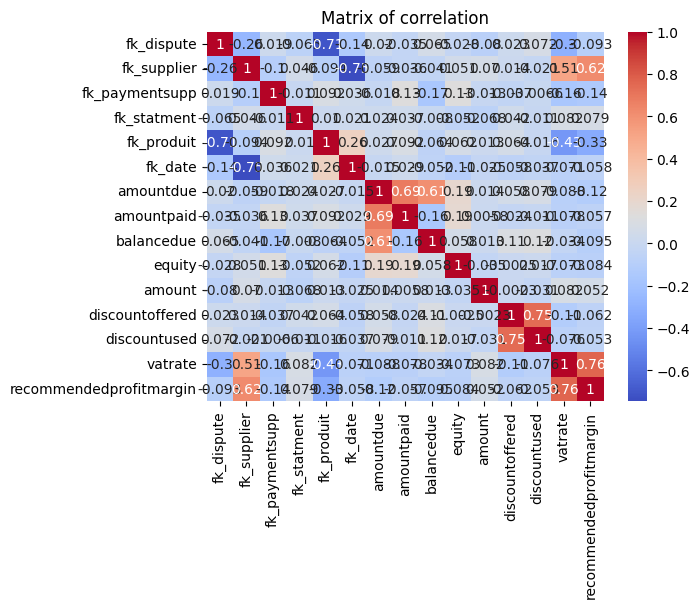

In [6]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrix of correlation')

In [4]:
df = df.rename(columns={'fk_supplier': 'id_supplier'})

In [5]:
#Drop all foreign key columns (columns that start with 'Fk_' or 'FK_')
fk_columns = [col for col in df.columns if col.startswith('fk_') or col.startswith('FK_')]
df.drop(columns=fk_columns, inplace=True)
df.dropna(inplace=True)

In [6]:
# Target: How much of offered discount was used
df['discount_effectiveness'] = df['discountused'] / df['discountoffered']

Text(0.5, 1.0, 'Matrix of correlation')

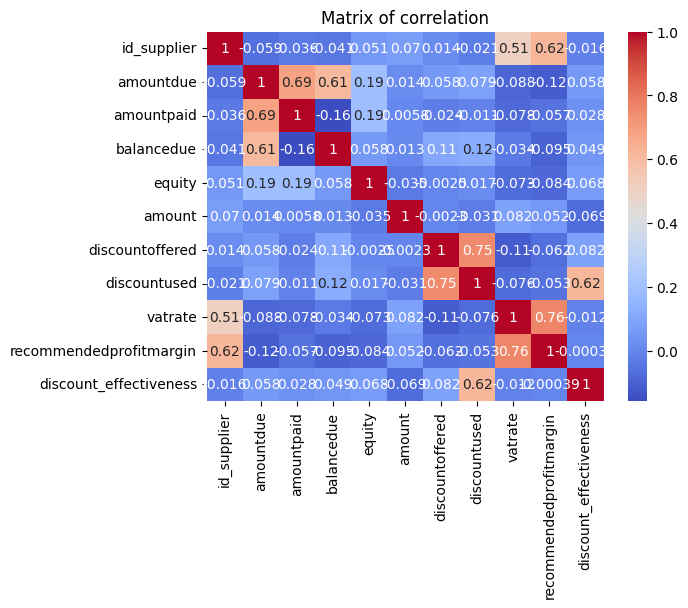

In [7]:
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Matrix of correlation')

In [11]:
selected_features = correlation['discount_effectiveness'][abs(correlation['discount_effectiveness']) > 0.1].index.tolist()
print("Selected Features:", selected_features)

Selected Features: ['discountused', 'discount_effectiveness']


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_supplier              283 non-null    int64  
 1   amountdue                283 non-null    float64
 2   amountpaid               283 non-null    float64
 3   balancedue               283 non-null    float64
 4   equity                   283 non-null    float64
 5   amount                   283 non-null    float64
 6   discountoffered          283 non-null    float64
 7   discountused             283 non-null    float64
 8   vatrate                  283 non-null    float64
 9   recommendedprofitmargin  283 non-null    float64
 10  discount_effectiveness   283 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 24.4 KB


In [9]:
print(df.columns.tolist())

['id_supplier', 'amountdue', 'amountpaid', 'balancedue', 'equity', 'amount', 'discountoffered', 'discountused', 'vatrate', 'recommendedprofitmargin', 'discount_effectiveness']


In [10]:
columns_to_drop = ['id_supplier', 'discoamountdue', 'amountpaid', 'balancedue', 
                  'equity', 'amount', 'vatrate', 'recommendedprofitmargin','amountdue']

for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(columns=[col])

In [11]:
print(df.columns.tolist())

['discountoffered', 'discountused', 'discount_effectiveness']


In [12]:
df.to_csv('FactAudit_LR.csv', index=False)

3. Split the data:

In [16]:
X = df.drop('discount_effectiveness', axis = 1).values
X2 = df.drop('discount_effectiveness', axis = 1)
y = df['discount_effectiveness']

print(X.shape)
print(y.shape)

X

(283, 2)
(283,)


array([[71.790000, 40.360000],
       [317.410000, 200.400000],
       [456.710000, 270.010000],
       [134.770000, 125.300000],
       [12.760000, 1.560000],
       [290.800000, 52.110000],
       [356.870000, 103.680000],
       [306.380000, 55.940000],
       [407.540000, 35.910000],
       [300.680000, 95.280000],
       [410.800000, 324.480000],
       [22.540000, 7.720000],
       [161.550000, 73.560000],
       [492.560000, 279.730000],
       [39.710000, 27.650000],
       [498.720000, 257.410000],
       [264.730000, 137.910000],
       [239.910000, 170.230000],
       [342.340000, 305.990000],
       [353.720000, 327.840000],
       [145.270000, 11.000000],
       [134.500000, 130.550000],
       [446.070000, 263.250000],
       [433.280000, 201.920000],
       [108.110000, 51.600000],
       [401.990000, 304.800000],
       [469.280000, 433.880000],
       [353.290000, 126.600000],
       [154.550000, 150.770000],
       [28.480000, 2.870000],
       [102.960000, 54.850000]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size = 0.3, random_state=42, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(198, 2)
(85, 2)
(198,)
(85,)


In [18]:
# Convert X_train to a DataFrame to use the head() method
pd.DataFrame(X_train).head()

,0,1
0,424.83,398.47
1,102.15,66.68
2,386.66,304.35
3,249.90,232.85
4,150.94,101.47


In [19]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

4. Select a model /Train the model

In [20]:
from sklearn.ensemble import ExtraTreesRegressor 
et = ExtraTreesRegressor(n_estimators=100, random_state=42)
et.fit(X_train, y_train)

y_pred = et.predict(X_train)

In [21]:
# Model Accuracy on training dataset

print('The Accuracy  on the training dataset is: ', et.score(X_train, y_train) )
print('The Accuracy n2  on the training dataset is: ',r2_score(y_train,y_pred) )   

print("")
# Model Accuracy on testing dataset
print('The Accuracy  on the testing dataset is: ', et.score(X_test, y_test) )

print("")
# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,y_pred)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test,et.predict(X_test))))

print("")
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train,y_pred))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test,et.predict(X_test)))


# Removed lines as ExtraTreesRegressor does not have coef_ or intercept_ attributes

The Accuracy  on the training dataset is:  1.0
The Accuracy n2  on the training dataset is:  1.0

The Accuracy  on the testing dataset is:  0.979376570454602

The RMSE  on the training dataset is:  8.161122843477995e-16
The RMSE  on the testing dataset is:  0.03919990236915335

The MAE  on the training dataset is:  6.209806273290562e-16
The MAE  on the testing dataset is:  0.022803724440428302


Evaluate the model:

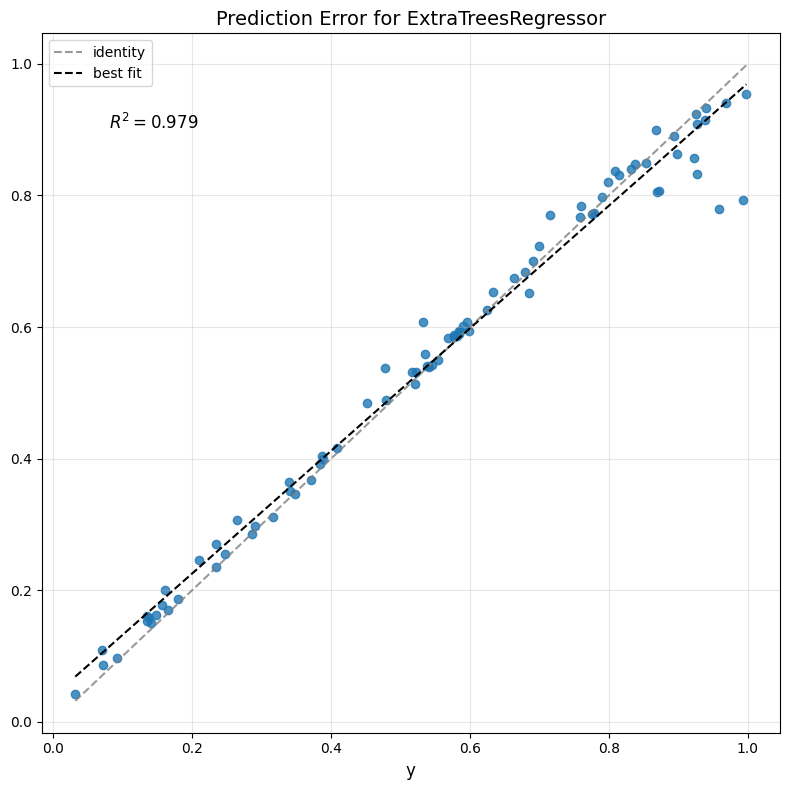

In [22]:
# Make predictions
y_pred = et.predict(X_test)

# Calculate R²
r2 = r2_score(y_test, y_pred)

# Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, color='#1f77b4', alpha=0.8)

# Add the best fit line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
line = np.linspace(min_val, max_val, 100)
plt.plot(line, line, '--', color='gray', alpha=0.8, label='identity')

# Add trend line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(line, p(line), '--', color='black', label='best fit')

# Add R² annotation
plt.text(min_val + 0.05*(max_val-min_val), max_val - 0.1*(max_val-min_val), 
         f'$R^2 = {r2:.3f}$', fontsize=12)

# Customize plot
plt.xlabel('y', fontsize=12)
plt.ylabel('', fontsize=12)
plt.grid(True, alpha=0.3)
plt.title('Prediction Error for ExtraTreesRegressor', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#train the model with cross-validation
from sklearn.model_selection import cross_val_score

cross_val_score(et, X_train, y_train, cv=10, scoring ='r2').mean()

0.9643859662660187

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Train multiple models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

Evaluate the model:

Linear Regression Results:
Mean Squared Error: 0.0220
R² Score: 0.7050
---------------------
Random Forest Results:
Mean Squared Error: 0.0027
R² Score: 0.9632
---------------------
Top 5 Most Important Features:
           Feature  Importance
1     discountused    0.671855
0  discountoffered    0.328145


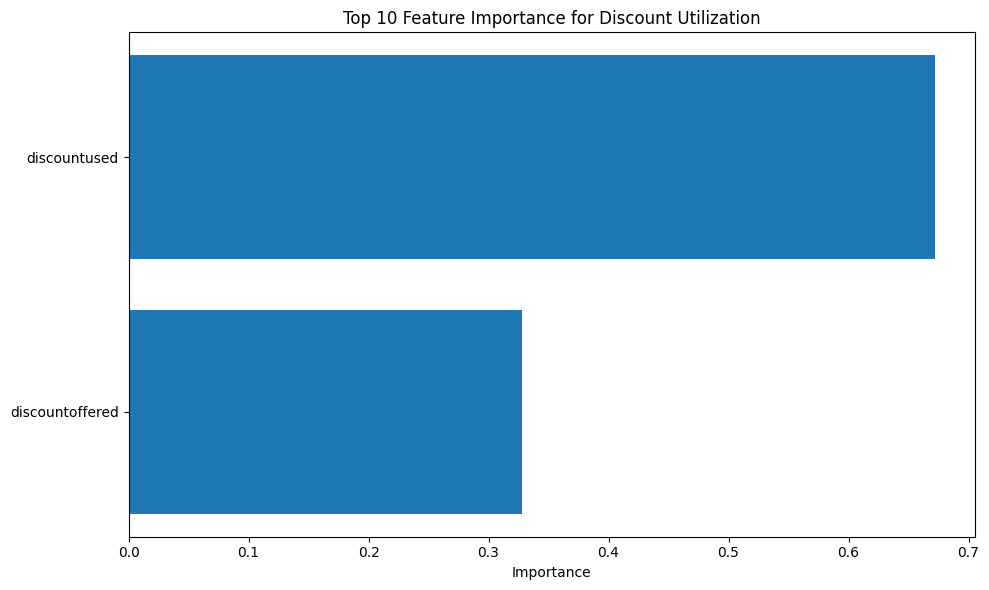

In [24]:
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} Results:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("---------------------")
    
    # For the Random Forest model, also check feature importance
    if name == 'Random Forest':
        feature_importance = pd.DataFrame({
            'Feature': X2.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("Top 5 Most Important Features:")
        print(feature_importance.head(5))
        
        # Visualize feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
        plt.xlabel('Importance')
        plt.title('Top 10 Feature Importance for Discount Utilization')
        plt.gca().invert_yaxis()  # To have the highest importance at the top
        plt.tight_layout()
        plt.show()

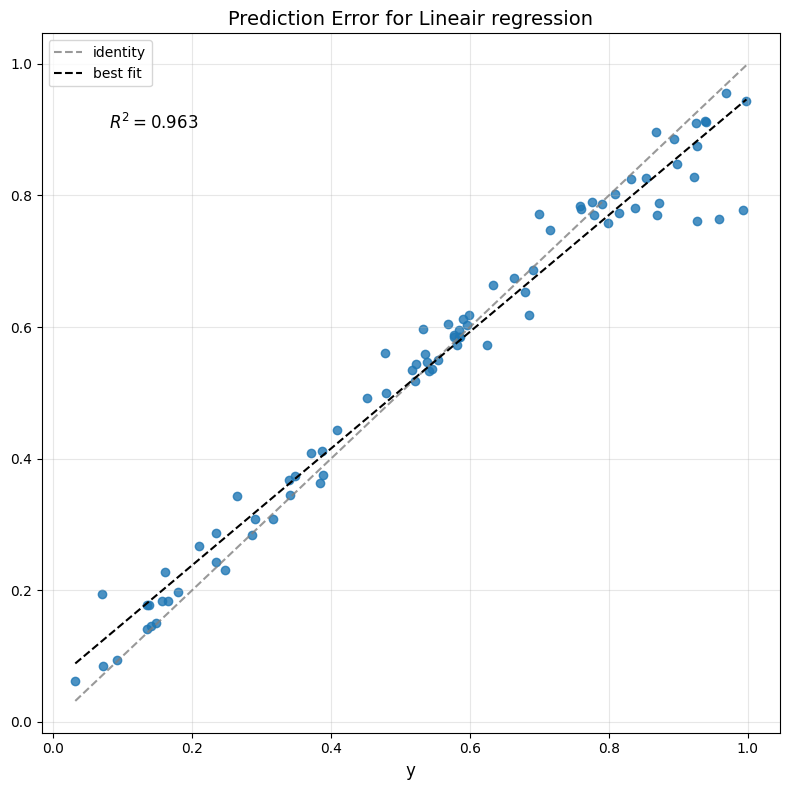

In [25]:
# Make predictions
# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate R²
r2 = r2_score(y_test, y_pred)

# Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, color='#1f77b4', alpha=0.8)

# Add the best fit line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
line = np.linspace(min_val, max_val, 100)
plt.plot(line, line, '--', color='gray', alpha=0.8, label='identity')

# Add trend line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(line, p(line), '--', color='black', label='best fit')

# Add R² annotation
plt.text(min_val + 0.05*(max_val-min_val), max_val - 0.1*(max_val-min_val), 
         f'$R^2 = {r2:.3f}$', fontsize=12)

# Customize plot
plt.xlabel('y', fontsize=12)
plt.ylabel('', fontsize=12)
plt.grid(True, alpha=0.3)
plt.title('Prediction Error for Lineair regression', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

==> So we can choose the best model which is ExtraTreesRegressor  with accuracy 0,97 

Saving The Model

In [26]:
import joblib

# Save the Model
joblib.dump(et, 'discount_utilization_model.pkl')


['discount_utilization_model.pkl']

In [27]:
final_df = et.predict(X_train)
final_df.head(20) 
final_df.to_csv('predictions_LR.csv', index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
prr=pd.read_csv(r"C:\Users\lynda\OneDrive\Desktop\BiPi\Final_versionML\predictions_LR.csv")
prr.head()

,discountoffered,discountused,discount_effectiveness,prediction_label
0,346.60,122.47,0.353347,0.353347
1,33.04,26.53,0.802966,0.802966
2,429.62,57.68,0.134258,0.160363
3,390.54,116.05,0.297153,0.297153
4,199.05,141.03,0.708515,0.708515


Test The model 

In [ ]:
# This is how you would load the model later
loaded_model = joblib.load(r'C:\Users\lynda\OneDrive\Desktop\BiPi\Final_versionML\discount_utilization_model.pkl')


# Let's create a sample new transaction to test
new_transaction = {
    'discountoffered': 429.62,
    'discountused':57.68
    
}

# Convertir en DataFrame
new_transaction_df = pd.DataFrame([new_transaction])

# Prédiction du discount effectiveness
predicted_effectiveness = loaded_model.predict(new_transaction_df)[0]

# Calcul réel de discount_effectiveness
true_effectiveness = new_transaction['discountused'] / new_transaction['discountoffered']

# Afficher les résultats
print(f"Predicted discount effectiveness: {predicted_effectiveness:.2%}")
print(f"Real discount effectiveness: {true_effectiveness:.2%}")

# Pour aller plus loin : prédire combien de dollars utilisés avec l'estimation
predicted_discount_used = new_transaction['discountoffered'] * predicted_effectiveness
print(f"Predicted discount used in $: {predicted_discount_used:.2f}")

Predicted discount effectiveness: 16.04%
Real discount effectiveness: 13.43%
Predicted discount used in $: 68.90
